# Homework 1 - Deep Learning Systems - FA19-BL-ENGR-E533 <a class="tocSkip"> 

## Importing libraries and setting up environment

### Importing Libraries

In [0]:
import os
from scipy.io import wavfile
import librosa
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import IPython.display as ipd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

### Checking Cuda



In [2]:
print("Number of cuda gpus: ",torch.cuda.device_count())
print("Current device name: ", torch.cuda.get_device_name(0))

# Store gpu device for further use
device=torch.device('cuda:0')

Number of cuda gpus:  1
Current device name:  Tesla K80


### Flag to indicate use of google drive through *pydrive* package

In [0]:
gdrive_connect = False

### Establishing PyDrive connection to google drive

In [0]:
if gdrive_connect:
  # Import PyDrive and associated libraries.
  # This only needs to be done once per notebook.
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # Authenticate and create the PyDrive client.
  # This only needs to be done once per notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)



### Creating data directory for data and result
- If not utilizing gdrive, upload data.zip for HW 1 - Problem 2 files to following path, and then run subsequent cells

In [0]:
download_path = os.path.expanduser('/content/results/')
try:
  os.makedirs(download_path)
  print("Directory created: ", download_path)
except FileExistsError:
  pass


In [6]:
data_path = os.path.expanduser('/content/data/')
try:
  os.makedirs(data_path)
  print("Directory created: ", data_path)
except FileExistsError:
  pass
###### If not utilizing gdrive, upload data.zip for HW 1 - Problem 2 files to following path, and then run subsequent cells:
print("Please upload data.zip (HW1 - Problem 2 data) on following path: ",data_path)

Please upload data.zip (HW1 - Problem 2 data) on following path:  /content/data/


## Problem 1: A Detailed View to MNIST Classification [5 points]


### Loading MNIST dataset
- Loading MNIST train and test images from the *torchvision* library, using *torch.utils.data.DataLoader* 

In [0]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('/path/to/mnist/folder/',
                train=True,
                download=True,
                transform=transforms.Compose([
                transforms.ToTensor()
                ])),
                batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('/path/to/mnist/folder/',
                train=False,
                download=True,
                transform=transforms.Compose([
                transforms.ToTensor()
                ])),
                batch_size=batch_size, shuffle=True)

### Explore and Visualize the *loaded* MNIST data

In [8]:
print("Training data images: ",len(train_loader.dataset))
print("Test data images: ", len(test_loader.dataset))

Training data images:  60000
Test data images:  10000


In [0]:
# Extract one batch from pytorch DataLoader
examples = enumerate(test_loader)
batch_id, (example_data, example_targets) = next(examples)

In [10]:
print("Shape of image tensor: ",example_data.shape)
print("Image targets: ",np.unique(example_targets))

Shape of image tensor:  torch.Size([128, 1, 28, 28])
Image targets:  [0 1 2 3 4 5 6 7 8 9]


In [11]:
# Tensor properties
print("Training tensor shape: ",(example_data[0].shape))
print("Training tensor dtype: ",(example_data[0].dtype))
print("Training tensor device: ",(example_data[0].device))
print("Training tensor layout: ",(example_data[0].layout))

Training tensor shape:  torch.Size([1, 28, 28])
Training tensor dtype:  torch.float32
Training tensor device:  cpu
Training tensor layout:  torch.strided


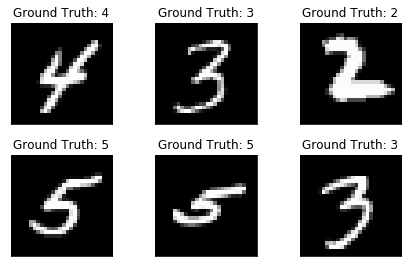

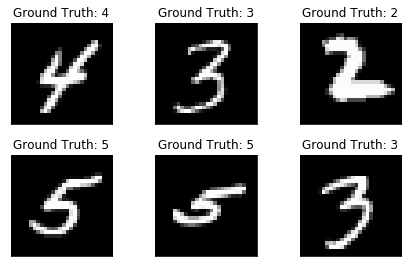

In [12]:
# Visualize data sample
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### 1.1, 1.2 Training fully connected neural network
- 5 layers
- 1024 hidden units

#### Defining PyTorch neural network class with feed forward function

In [0]:
# Parameters used in network architecture
input_size = 28 * 28
hidden_size = 1024
target_size = 10

class FCN5(nn.Module):
  def __init__(self):
    super(FCN5, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, hidden_size)
    self.fc4 = nn.Linear(hidden_size, hidden_size)
    self.fc5 = nn.Linear(hidden_size, hidden_size)
    self.fc6 = nn.Linear(hidden_size, hidden_size)
    self.fc7 = nn.Linear(hidden_size, target_size)

  # Feed forward network with an "all_layers" command to extract output from all layers as a dictionary
  def forward(self, x, all_layers = False):
    output_dict = {}
    x = self.fc1(x)
    x = F.relu(x)
    output_dict.update( {'x1' : x} )

    x = self.fc2(x)
    x = F.relu(x)
    output_dict.update( {'x2' : x} )

    x = self.fc3(x)
    x = F.relu(x)
    output_dict.update( {'x3' : x} )

    x = self.fc4(x)
    x = F.relu(x)
    output_dict.update( {'x4' : x} )

    x = self.fc5(x)
    x = F.relu(x)
    output_dict.update( {'x5' : x} )

    x = self.fc6(x)
    x = F.relu(x)
    output_dict.update( {'x6' : x} )

    x = self.fc7(x)
    x = F.log_softmax(x, dim = 1)
    output_dict.update( {'x7' : x} )

    if all_layers:
      return x, output_dict
    else:
      return x  
    

#### Set up connection to drive for saving model results

In [0]:
if gdrive_connect:
  file_list = drive.ListFile({'q': "title='model_tuned.pth' and trashed=false"}).GetList()
  print(file_list)
  if len(file_list) == 1:
      print(file_list[0]['id'])

#### Defining neural network training function

In [0]:
epochs = 20
learning_rate = 0.0005
train_losses = []

def train(epoch):

  total_train_loss = 0
  correct_train = 0

  # Set network mode to train
  net.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    
    # Use cuda device to access data and labels
    data = data.to(device)
    target = target.to(device)
    
    # Flatten MNIST images into a 784 long vector
    data = data.view(data.shape[0], -1).to(device)

    # Initialize zero gradients
    optimizer.zero_grad()

    # Train neural network on dataset
    output = net(data)

    # Get training loss
    train_loss = loss(output, target)
    
    # Perform backpropagation
    train_loss.backward()
    optimizer.step()
    
    # Summing losses for all batches
    total_train_loss += train_loss.item()

    # Store correct predictions
    pred = output.data.max(1, keepdim=True)[1]
    correct_train += pred.eq(target.data.view_as(pred)).sum()
    
    # Store training loss
    train_losses.append(train_loss.item())
    
  print('Train Epoch: {}\nTrain Loss = {:.4f} \t Train Accuracy = {:.3f}%'.format(
    epoch, train_loss.item(), (100.0 * correct_train.item())/len(train_loader.dataset)*1.0))
  
  
  
  # Save model
  torch.save(net.state_dict(), download_path + 'model_tuned.pth')
  torch.save(optimizer.state_dict(), download_path + 'optimizer.pth')

  # Save model to drive
  if gdrive_connect:
    net_file.SetContentFile(download_path + 'model_tuned.pth')
    net_file.Upload()
  test()      

#### Defining neural network testing function

In [0]:
test_losses = []


def test():
  net.eval()
  total_test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:

      # Use cuda device to access data and labels
      data = data.to(device)
      target = target.to(device)

      # Flatten MNIST images into a 784 long vector
      data = data.view(data.shape[0], -1).to(device)

      # Perform feed forward step
      output = net(data).to(device)

      # Store batch test loss
      test_loss = loss(output, target)
      total_test_loss += test_loss.item()
      
      # Get prediction, i.e max predicted probability dimension
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()



  print('Test loss = {:.4f} \t Test Accuracy = {:.3f}%\n'.format(
    test_loss.item(), 
    (100*correct.item()) / (len(test_loader.dataset)*1.0)))
  

#### Creating neural network model object

In [0]:
net = FCN5()
net = net.to(device)

#### Optimizer and loss function to be used

In [0]:

# define optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# define loss function
loss = nn.NLLLoss()

#### Training and testing neural network for multiple epochs

In [0]:
# Define model training parameters
epochs = 20
learning_rate = 0.0005
train_losses = []

In [20]:
timestr = time.strftime("%Y%m%d-%H%M%S")
print (timestr)

# Save model to drive
if gdrive_connect:
  net_file = drive.CreateFile({'title' : 'model_tuned_{}.pth'.format(timestr)})

# Run training loop for provided epochs
for _epoch in range(1, epochs + 1):
  # Training model using train function
  train(_epoch)

# Test the trained model on test dataset 
test()

# Save trained model
torch.save(net.state_dict(), download_path + 'final_model_tuned.pth')

timestr = time.strftime("%Y%m%d-%H%M%S")
print (timestr)

# Save final model to drive
if gdrive_connect:
  net_file = drive.CreateFile({'title' : 'final_model_tuned_{}.pth'.format(timestr)})

  net_file.SetContentFile(download_path + 'final_model_tuned.pth')
  net_file.Upload()      

20190929-232700
Train Epoch: 1
Train Loss = 0.0970 	 Train Accuracy = 89.740%
Test loss = 0.0706 	 Test Accuracy = 95.250%

Train Epoch: 2
Train Loss = 0.1553 	 Train Accuracy = 96.732%
Test loss = 0.0084 	 Test Accuracy = 97.330%

Train Epoch: 3
Train Loss = 0.0940 	 Train Accuracy = 97.865%
Test loss = 0.0003 	 Test Accuracy = 97.460%

Train Epoch: 4
Train Loss = 0.0310 	 Train Accuracy = 98.262%
Test loss = 0.0010 	 Test Accuracy = 97.610%

Train Epoch: 5
Train Loss = 0.0104 	 Train Accuracy = 98.725%
Test loss = 0.0135 	 Test Accuracy = 97.210%

Train Epoch: 6
Train Loss = 0.0392 	 Train Accuracy = 98.813%
Test loss = 0.0520 	 Test Accuracy = 97.980%

Train Epoch: 7
Train Loss = 0.0109 	 Train Accuracy = 99.025%
Test loss = 0.2033 	 Test Accuracy = 97.850%

Train Epoch: 8
Train Loss = 0.0288 	 Train Accuracy = 99.100%
Test loss = 0.1168 	 Test Accuracy = 98.080%

Train Epoch: 9
Train Loss = 0.0607 	 Train Accuracy = 99.230%
Test loss = 0.0335 	 Test Accuracy = 97.360%

Train Epoch:

#### Check model test accuracy

In [21]:
test()

Test loss = 0.0000 	 Test Accuracy = 98.330%



### 1.3  Feedforward step on last layer output


In [0]:
# Randomly extract test batch size 1000 using dataloader
test_sampler = torch.utils.data.DataLoader(
                datasets.MNIST('/path/to/mnist/folder/',
                train=False,
                download=True,
                transform=transforms.Compose([
                transforms.ToTensor()
                #,transforms.Normalize((0.1307,), (0.3081,))
                ])),
                batch_size=1000, shuffle=True)

# Get one batch of test data (1000 shuffled samples)
iterator = iter(test_sampler)
x_batch, y_batch = iterator.next()

In [23]:
print(x_batch.shape)
print(y_batch.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


#### Feedforward step


In [0]:
# Flatten MNIST test samples into a 784 long vector
x_batch_flat = x_batch.view(x_batch.shape[0], -1).to(device)

# Initialize zero gradients
optimizer.zero_grad()

# Predict using trained neural network
output = net(x_batch_flat)

In [0]:
# Get max dimension (predicted label) and probability from 10d probabilities
prob = output.data.max(1)[0]
pred = output.data.max(1)[1]


In [26]:
print(prob.shape, pred.shape)

torch.Size([1000]) torch.Size([1000])


#### Get unique labels from predictions

In [27]:
y_labels = np.unique(pred.cpu())
y_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Extract indices of images that have the highest probability for the predicted dimensions

In [0]:
max_prob_idx = [np.argsort(prob[y_batch==_label].cpu())[-10:] for _label in y_labels]

In [29]:
max_prob_idx

[tensor([32, 31, 30, 29, 28, 27, 26, 25, 96, 97]),
 tensor([ 29,  24,  26,  64,  63,  28,  61,  60,  66, 111]),
 tensor([43, 42, 41, 40, 39, 37, 36, 35, 33, 96]),
 tensor([57, 90, 42, 41, 38, 37, 31, 30, 44, 91]),
 tensor([43, 42, 41, 40, 39, 38, 35, 34, 55, 96]),
 tensor([31, 29, 28, 27, 26, 25, 24, 23, 30, 84]),
 tensor([ 47,  45,  44,  43,  42,  40,  37,  35,  33, 111]),
 tensor([ 42,  43,  44,  45,  58,  61,  67,  68,  73, 101]),
 tensor([39, 37, 36, 35, 34, 33, 32, 30, 26, 98]),
 tensor([ 36,  35,  34,  33,  32,  31,  30,  29,  57, 105])]

#### Extract images and corresponding model predictions as per the above indices

In [0]:
# Store 10 images and corresponding maximum predicted dimension
x_images = [x_batch[y_batch == _label][max_prob_idx[_label]] for _label in y_labels]
x_images_pred = [pred[y_batch == _label][max_prob_idx[_label]] for _label in y_labels]


#### Display grid of subplots for the above images, with their corresponding predicted dimensions 
- We see that the model correctly predicts MNIST test images
- Row 1 consists of images for ground truth "0" and the correct prediction of label "0" 
- Similarly all layer predictions are correct 

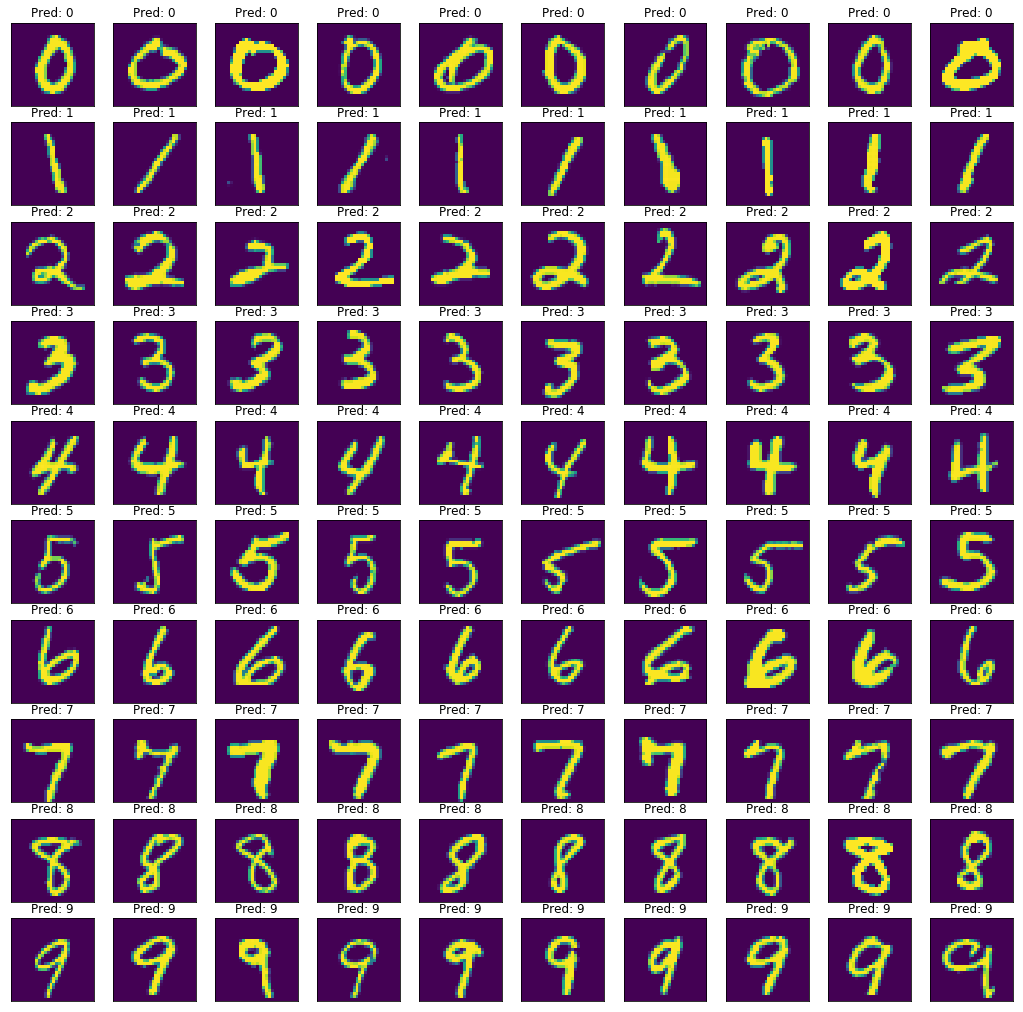

In [31]:
fig, ax = plt.subplots(nrows=10, ncols=10,figsize=(18,18))
plt.rcParams['font.size'] = 10
image_num = 1
for i in range(0, 10):
  for j in range(0, 10):
    
    ax[i,j].imshow(np.squeeze(x_images[i][j]))
    ax[i,j].set_title("Pred: {}".format(x_images_pred[i][j].item()))
    
    # Remove tick labels
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    
    image_num+=1

### 1.4 Feedforward on second last layer output

#### Feedforward step, with extraction of second last layer output

In [0]:
# Flatten MNIST test samples into a 784 long vector
x_batch_flat = x_batch.view(x_batch.shape[0], -1).to(device)

# Initialize zero gradients
optimizer.zero_grad()

# Predict using trained neural network
output, output_dict = net(x_batch_flat, all_layers = True)

In [33]:
print("Shape of second last layer output: ",output_dict['x6'].shape)

Shape of second last layer output:  torch.Size([1000, 1024])


#### Randomly selecting 10 dimensions

In [34]:
perm = torch.randperm(output_dict['x6'].size(1))
idx = perm[:10]
idx

tensor([ 83, 103, 990, 348, 480,  22, 182, 289, 555, 847])

In [35]:
output = output_dict['x6'][:, idx]
print("Shape of second last layer output, after randomly selected 10 dimensions: ",output.shape)

Shape of second last layer output, after randomly selected 10 dimensions:  torch.Size([1000, 10])


#### 

In [0]:
# Get max dimension (predicted label) and probability from 10d probabilities
prob = output.data.max(1)[0]
pred = output.data.max(1)[1]


In [37]:
print(prob.shape, pred.shape)

torch.Size([1000]) torch.Size([1000])


#### Get unique labels from predictions

#### Extract indices of images that have the highest probability for the predicted dimensions

In [38]:
y_labels = np.unique(pred.cpu())
y_labels

array([0, 2, 5, 9])

In [0]:
max_prob_idx = {_label : np.argsort(prob[y_batch==_label].cpu())[-min(10,len(prob[y_batch==_label])):] for _label in y_labels}

In [40]:
max_prob_idx

{0: tensor([ 4, 92, 25, 16,  9, 54, 66, 33, 24, 43]),
 2: tensor([44, 40, 36, 87, 47, 85, 37, 34, 15,  8]),
 5: tensor([ 6, 14, 75, 24, 25,  5, 57, 62, 32, 71]),
 9: tensor([46,  0, 73, 99, 35, 59, 26, 83, 63, 55])}

#### Extract images and corresponding model predictions as per above indices

In [0]:
# Store 10 images and corresponding maximum predicted dimension
x_images = {_label : x_batch[y_batch == _label][max_prob_idx[_label]] for _label in y_labels}
x_images_pred = {_label : pred[y_batch == _label][max_prob_idx[_label]] for _label in y_labels}


#### Display grid of subplots for the above images, with their corresponding predicted dimensions

**Observations**
- Due to random selection of 10 dimensions, images are missing for some of the ground truths
- As compared to 1.3, the classification is not ideal in the second to last layer, some of the images are misclassified for entire dimensions
- The classifier at this point contains features extracted through non-linearities, corresponding to input images
 - The particular dimensions we are looking at are features for the image, which will have a final layer weight associated
 - This weight will decide whether a feature is important for the model, hence it might be possible that the random 10 dimensions selected are not all important, or even have an opposite directional weight
 - Thus the output we see in the second last layer is as expected

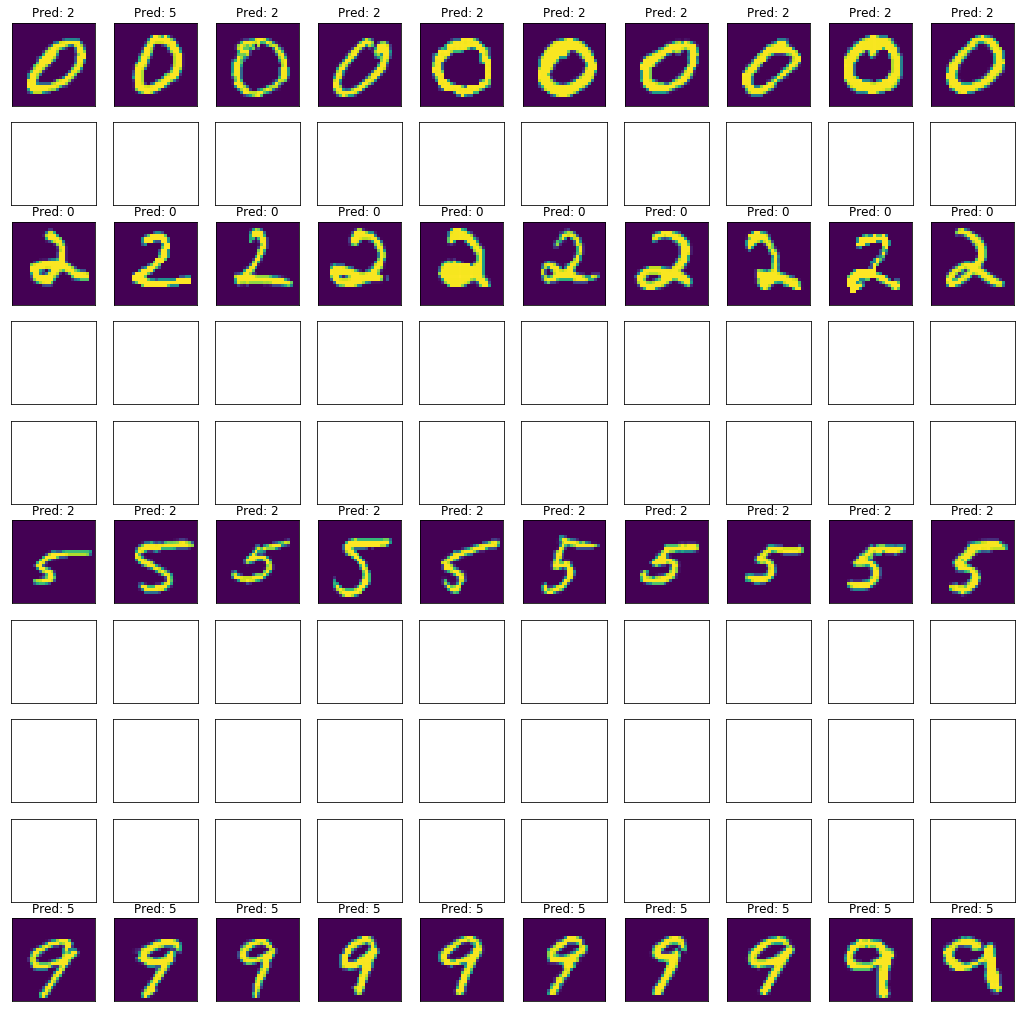

In [42]:
fig, ax = plt.subplots(nrows=10, ncols=10,figsize=(18,18))
plt.rcParams['font.size'] = 10
image_num = 1
for i in range(0, 10):
  for j in range(0, 10):
    try:
      ax[i,j].imshow(np.squeeze(x_images[i][j]))
      ax[i,j].set_title("Pred: {}".format(x_images_pred[i][j].item()))
      
      # Remove tick labels
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])
      
      image_num+=1
    except:
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])

### 1.5, 1.6, 1.7 tSNE and PCA on test sample

In [43]:
x_batch_flat.shape

torch.Size([1000, 784])

#### t-Stochastic Neighbor Embedding (tSNE) on input data

In [44]:
# tSNE on flattenned test batch
x_embedded_tsne = TSNE(n_components=2).fit_transform(x_batch_flat.cpu())
x_embedded_tsne.shape

(1000, 2)

In [45]:
y_labels = np.unique(y_batch)
y_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Define function for scatter plot with labels at group means

In [0]:
def scatter_2d(x_embedded, y, title = 'Scatter Plot'):
  
  # Define figure parameters
  fig, ax = plt.subplots(figsize = (15,15))
  fig.suptitle(title, fontsize=30)
  plt.rcParams['font.size'] = 25

  # Plot the embedded dims
  ax.scatter(x_embedded[:,0],x_embedded[:,1],
            c=y,
            cmap=plt.cm.get_cmap('gist_rainbow', 10) )

  mean = []
  
  # Plot group labels at group means
  for i in range(10):
    ind = np.where(y_batch == i)[0]
    y_sub = x_embedded[ind]
    x, y = (np.mean(y_sub, axis = 0))
    ax.annotate(str(i), xy=(x, y))
    
  return fig

#### Plotting tSNE output as a scatter plot

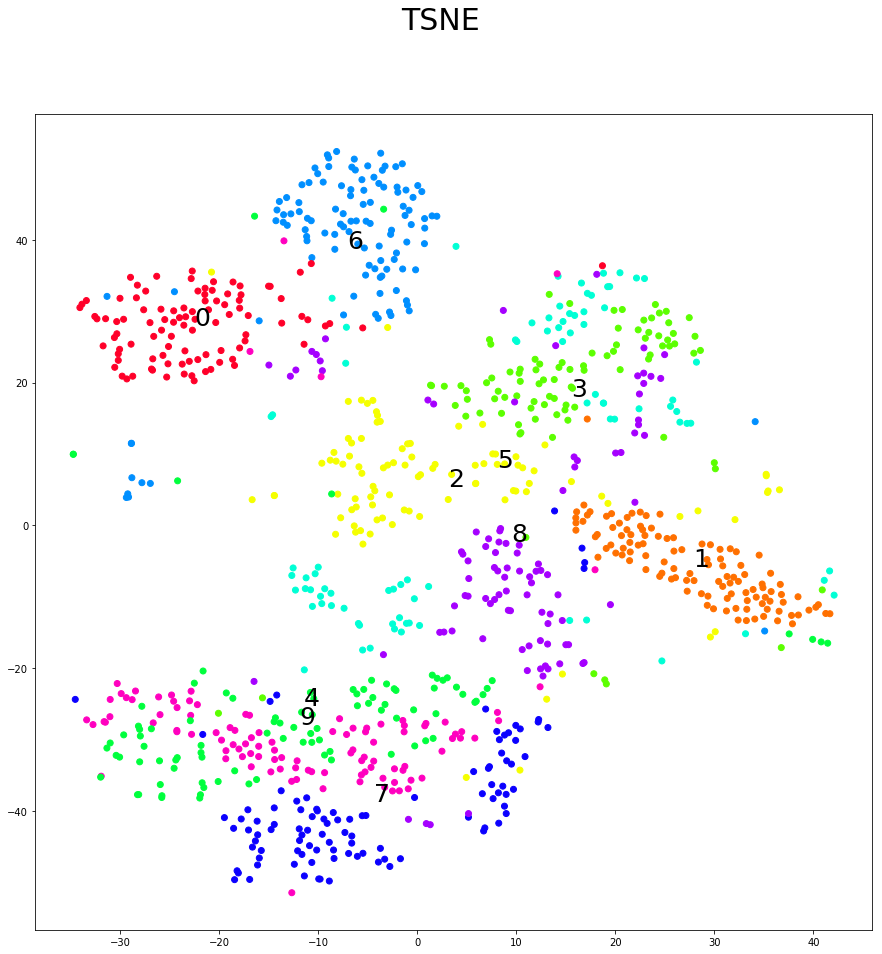

In [47]:
fig = scatter_2d(x_embedded_tsne, y_batch, 'TSNE')

#### Principal Component Analysis (PCA) on input data

In [0]:
pca = PCA(n_components=2)
x_embedded_pca = pca.fit_transform(x_batch_flat.cpu())  

In [49]:
x_embedded_pca.shape

(1000, 2)

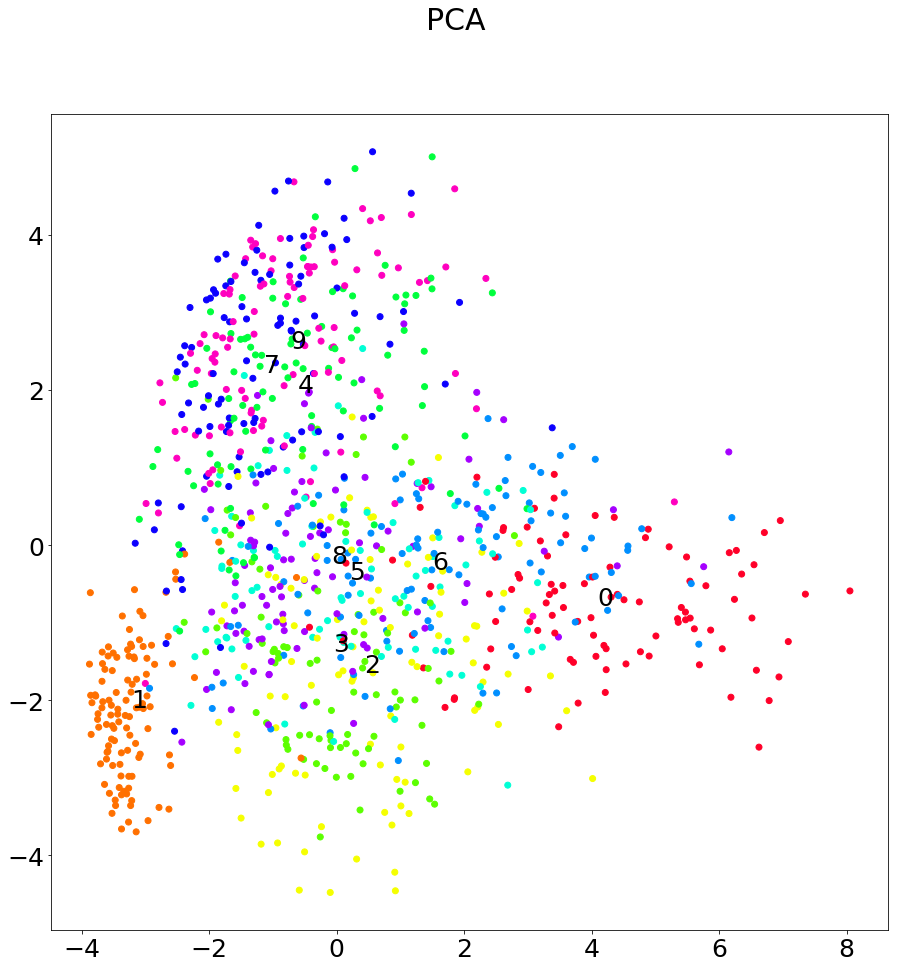

In [50]:
fig = scatter_2d(x_embedded_pca, y_batch, 'PCA')

### t-SNE and PCA on 1st hidden layer output from feedforward using classifier 

In [0]:
def tsne_embed_plot(x, y, title = 'Scatter Plot'):
  x_embedded_tsne = TSNE(n_components=2).fit_transform(x)
  fig = scatter_2d(x_embedded_tsne, y, title)
  

def pca_embed_plot(x, y, title = 'Scatter Plot'):
  pca = PCA(n_components=2)
  x_embedded_pca = pca.fit_transform(x)
  fig = scatter_2d(x_embedded_pca, y, title)
  


In [0]:
# Flatten MNIST test samples into a 784 long vector
x_batch_flat = x_batch.view(x_batch.shape[0], -1).to(device)

# Initialize zero gradients
optimizer.zero_grad()

# Predict using trained neural network
output, output_dict = net(x_batch_flat, all_layers = True)

In [53]:
output_dict['x2'].shape

torch.Size([1000, 1024])

#### PCA and tSNE Plots for 1st Hidden Layer

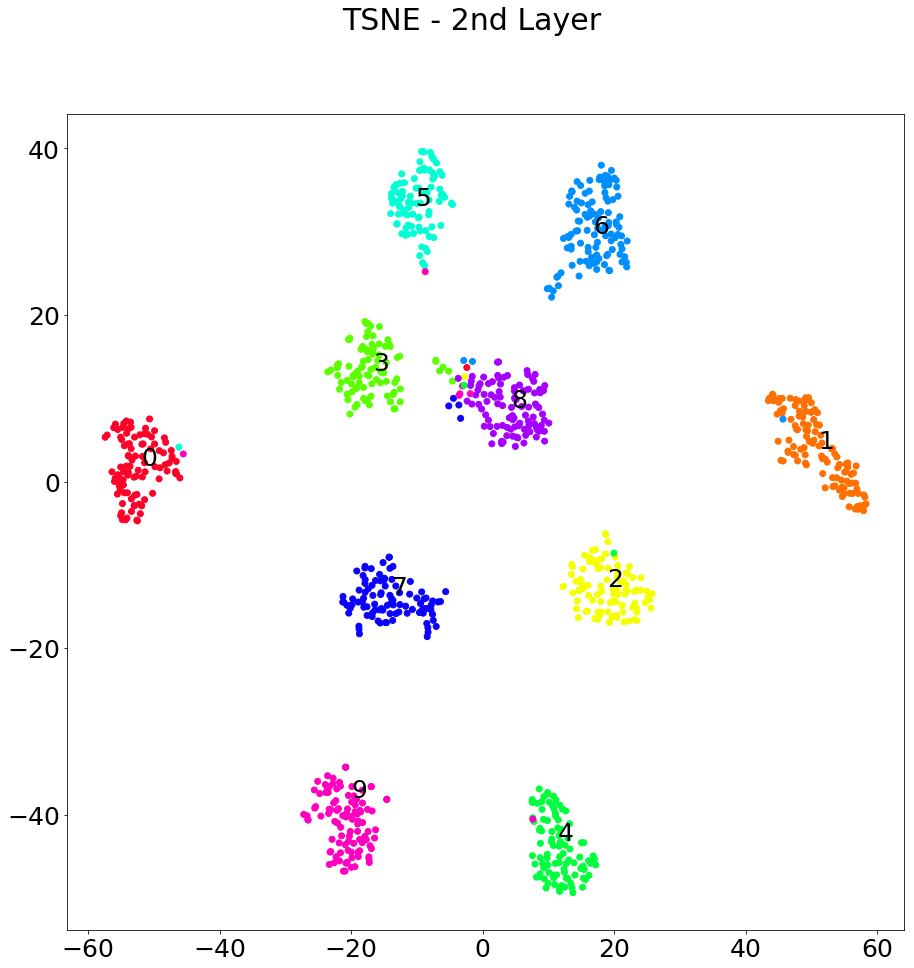

In [54]:
 tsne_embed_plot(output_dict['x2'].cpu().detach().numpy(), y_batch, 'TSNE - 2nd Layer')

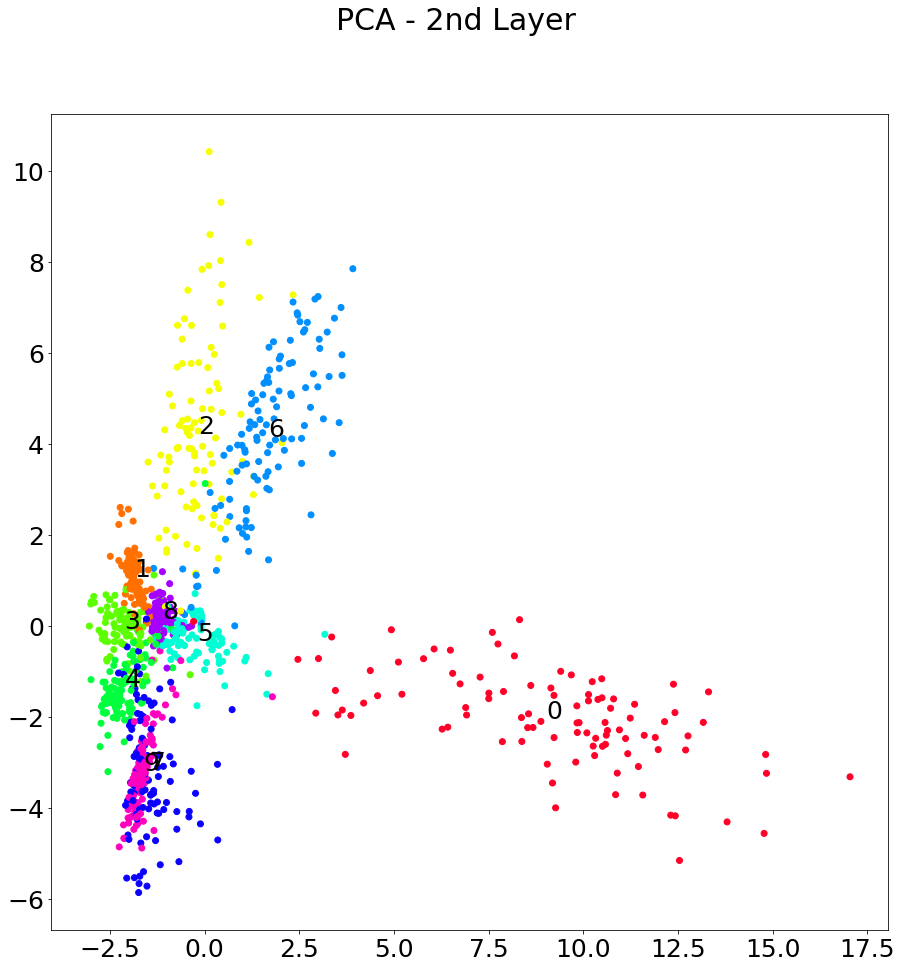

In [55]:
 pca_embed_plot(output_dict['x2'].cpu().detach().numpy(), y_batch, 'PCA - 2nd Layer')

### 1.8 All layers

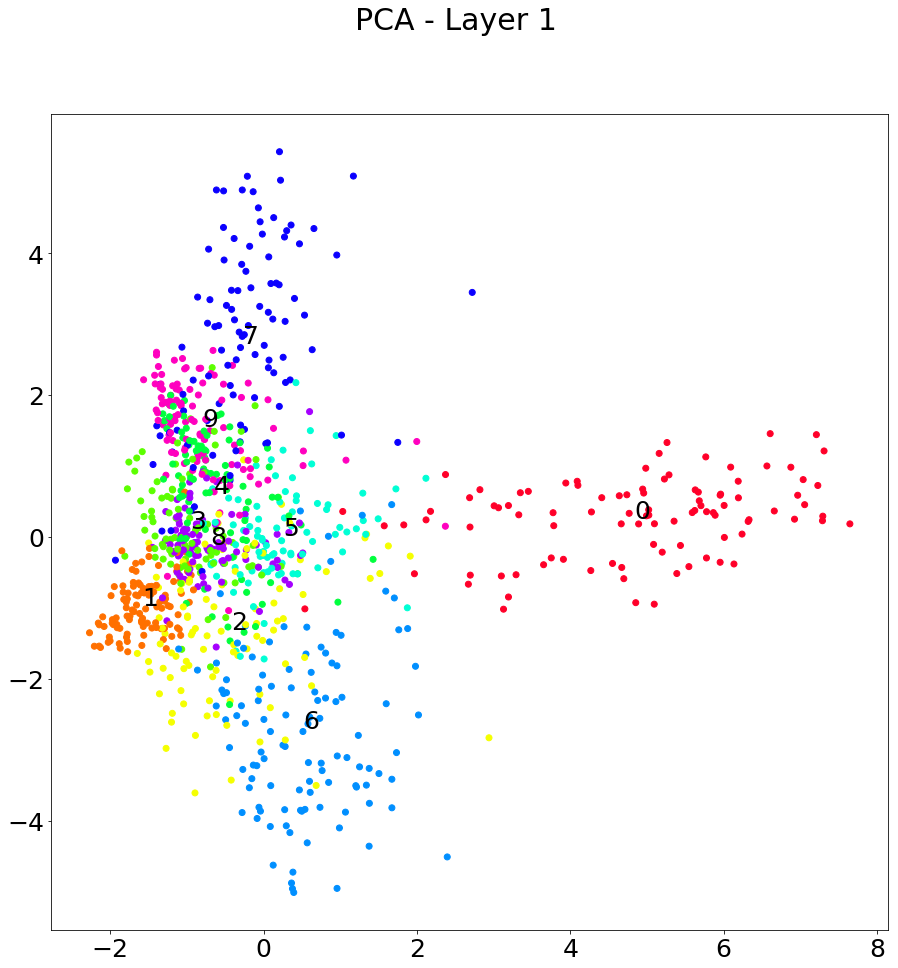

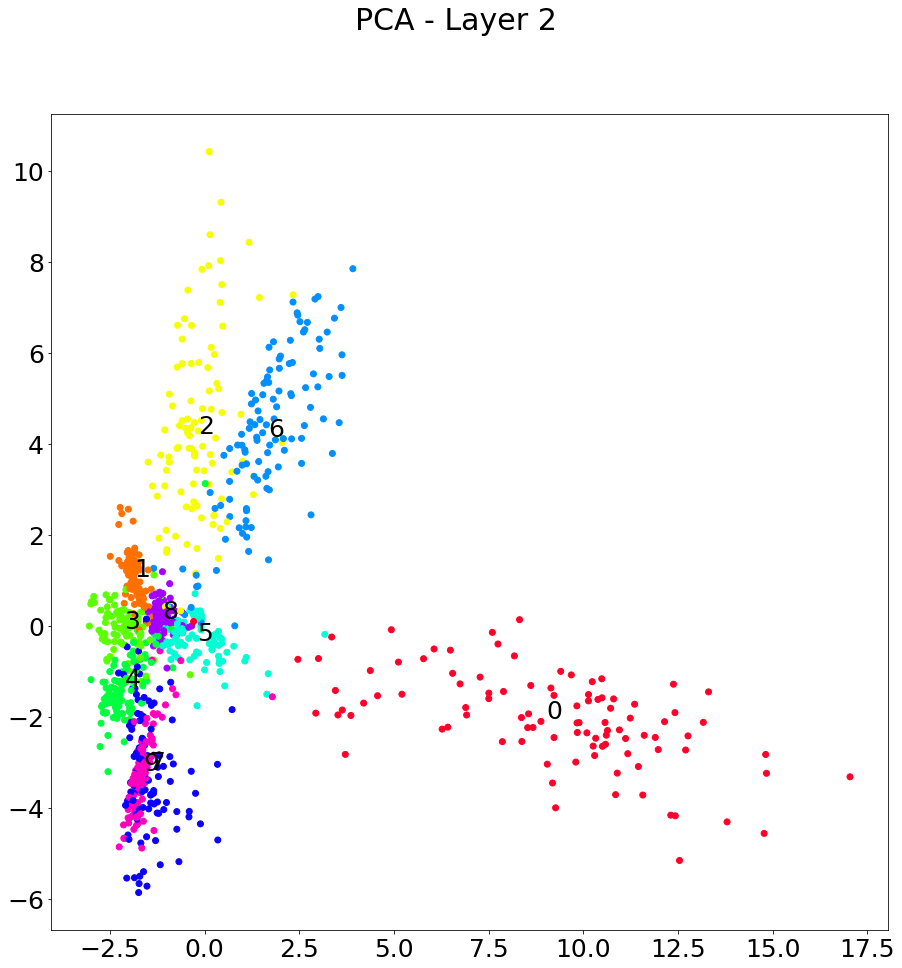

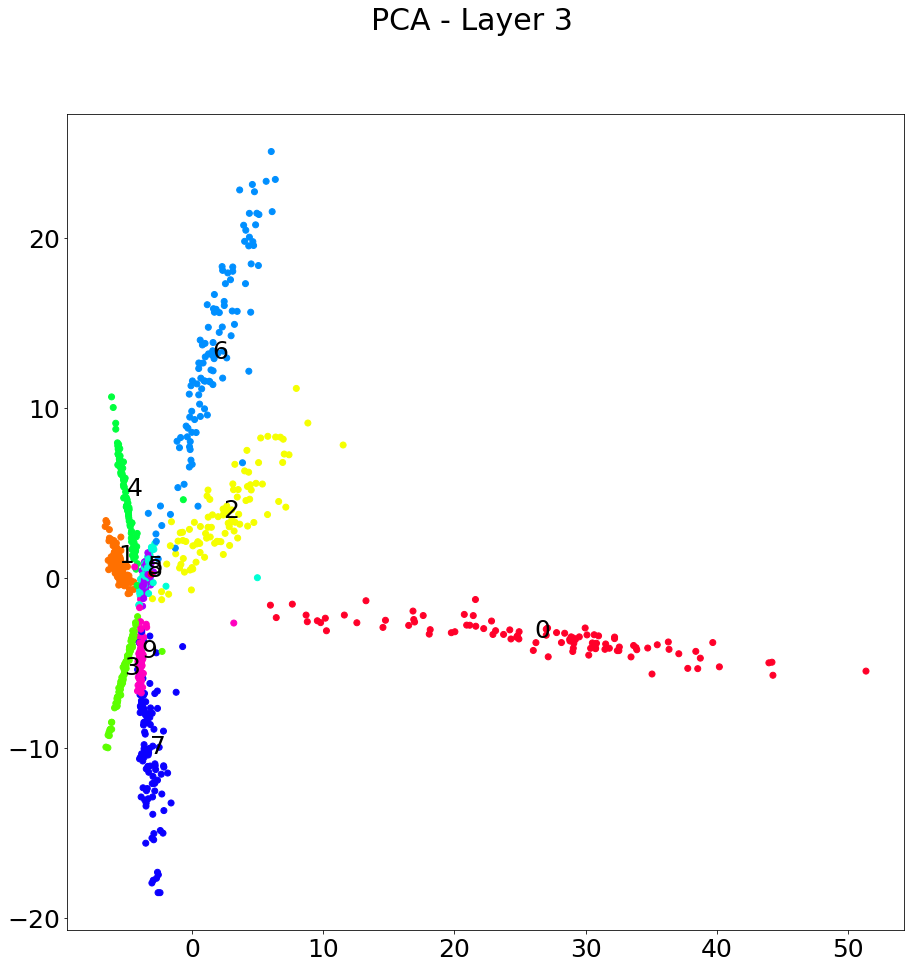

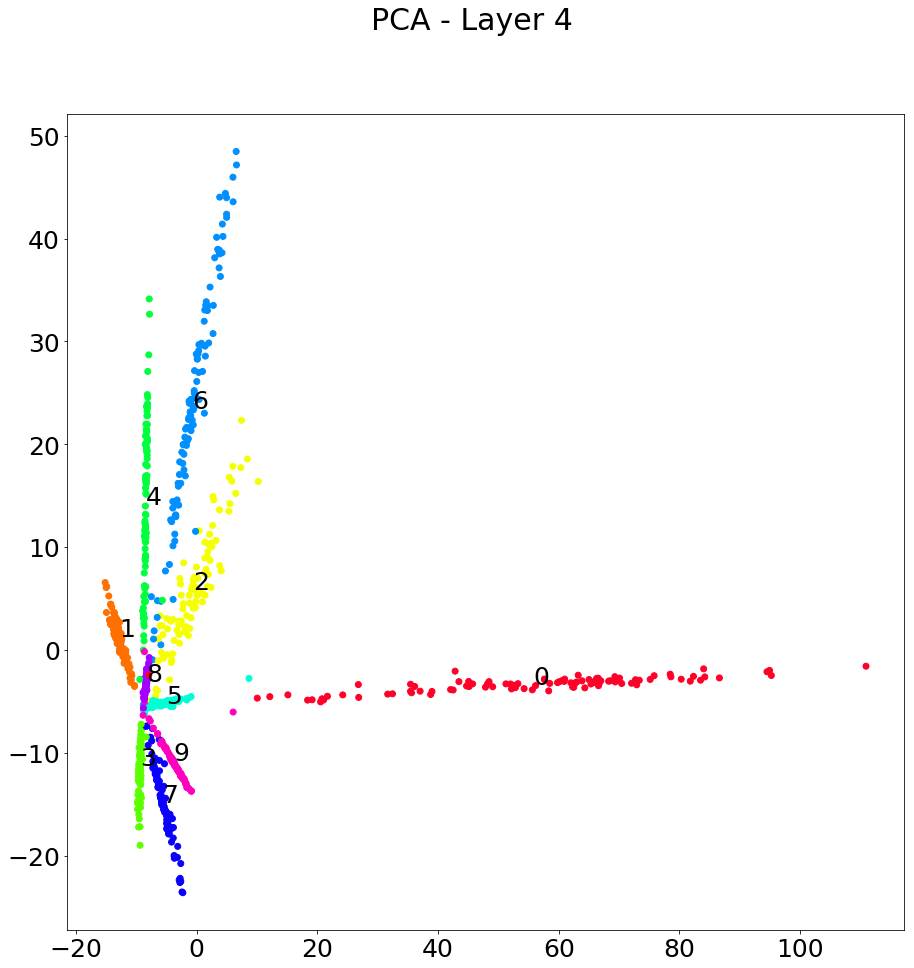

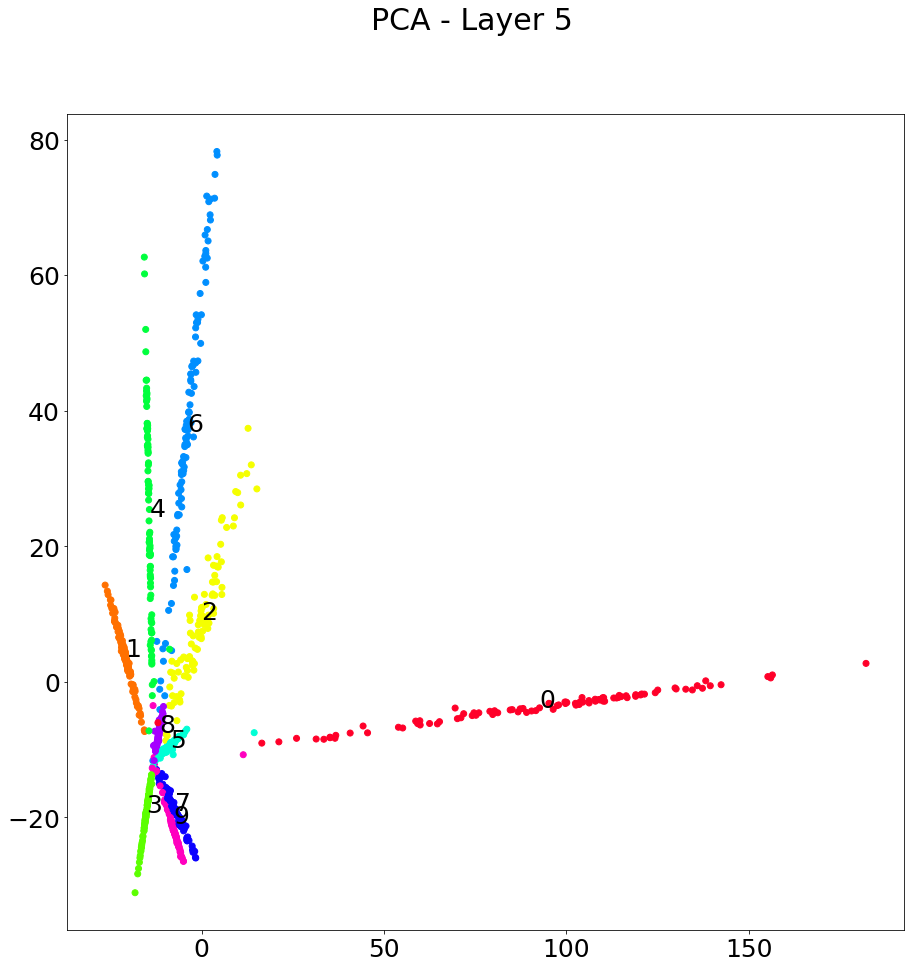

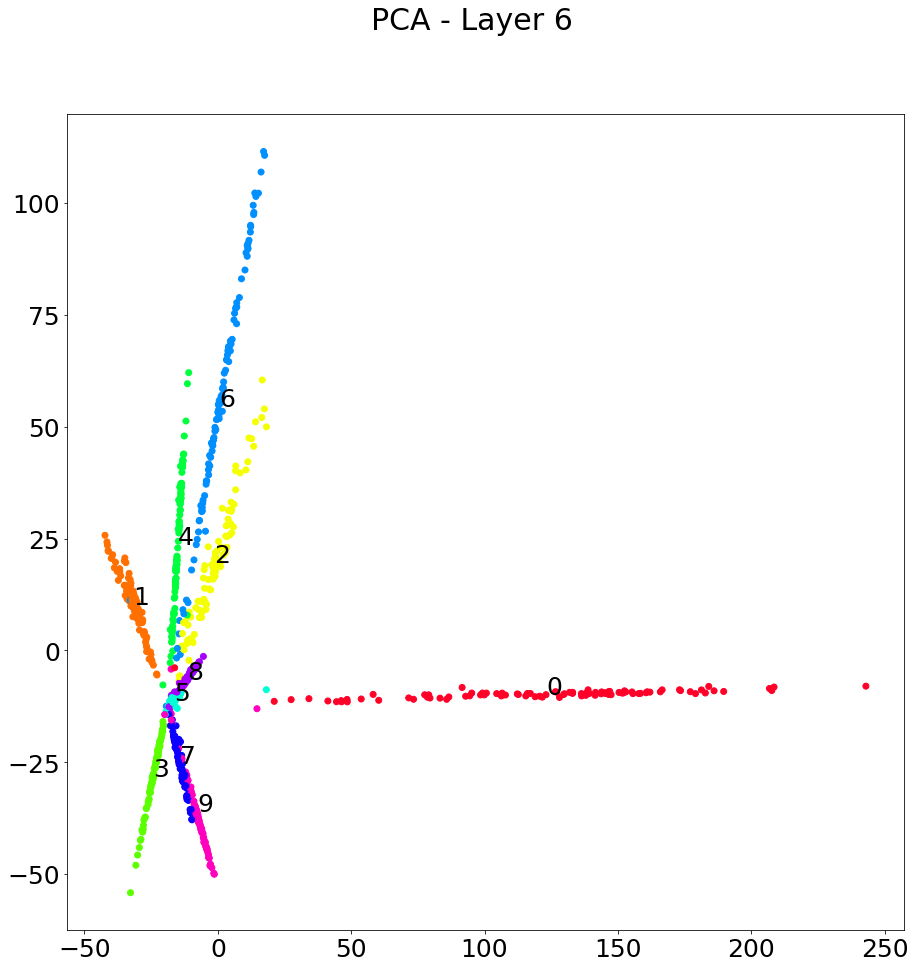

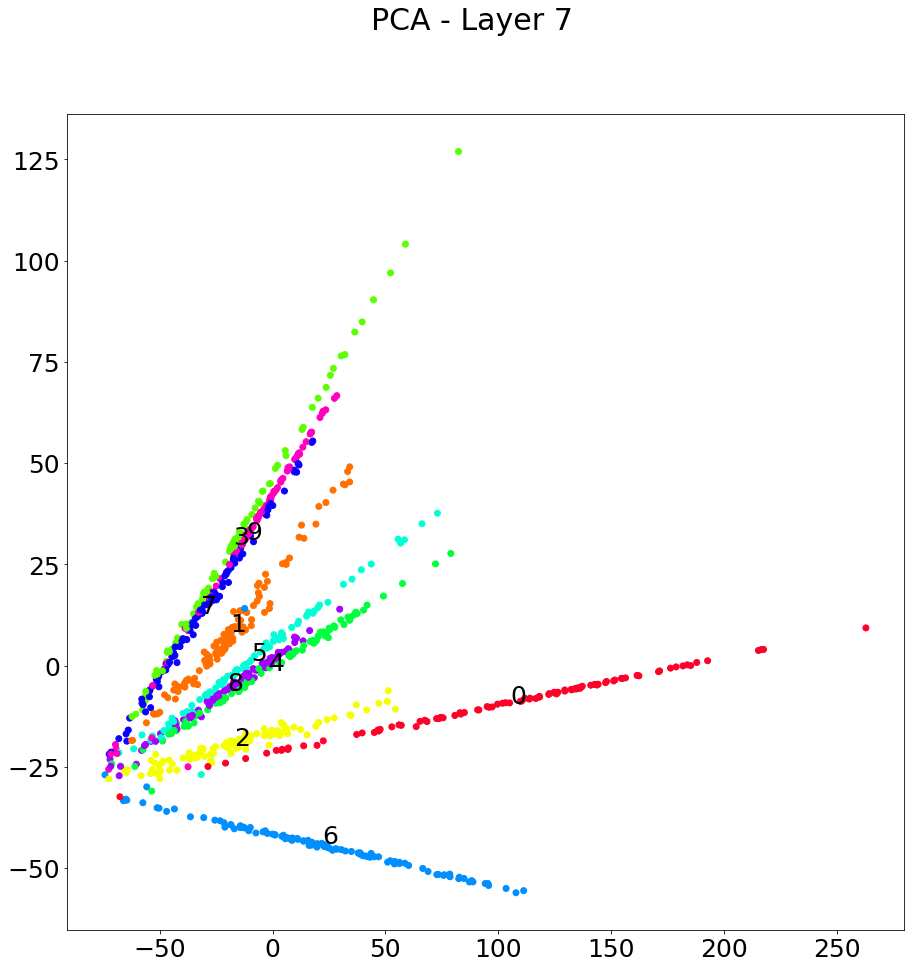

In [56]:
for _layer in output_dict.keys():
  pca_embed_plot(output_dict[_layer].cpu().detach().numpy(), y_batch, 'PCA - Layer {}'.format(_layer[1]))

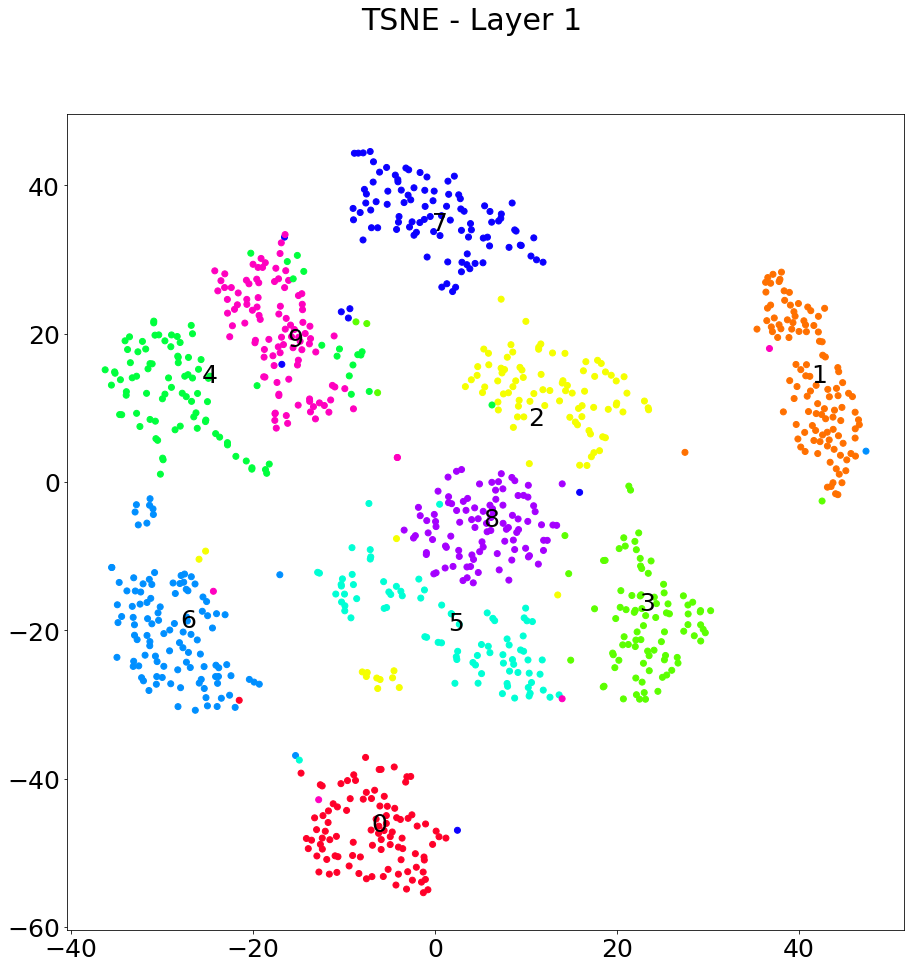

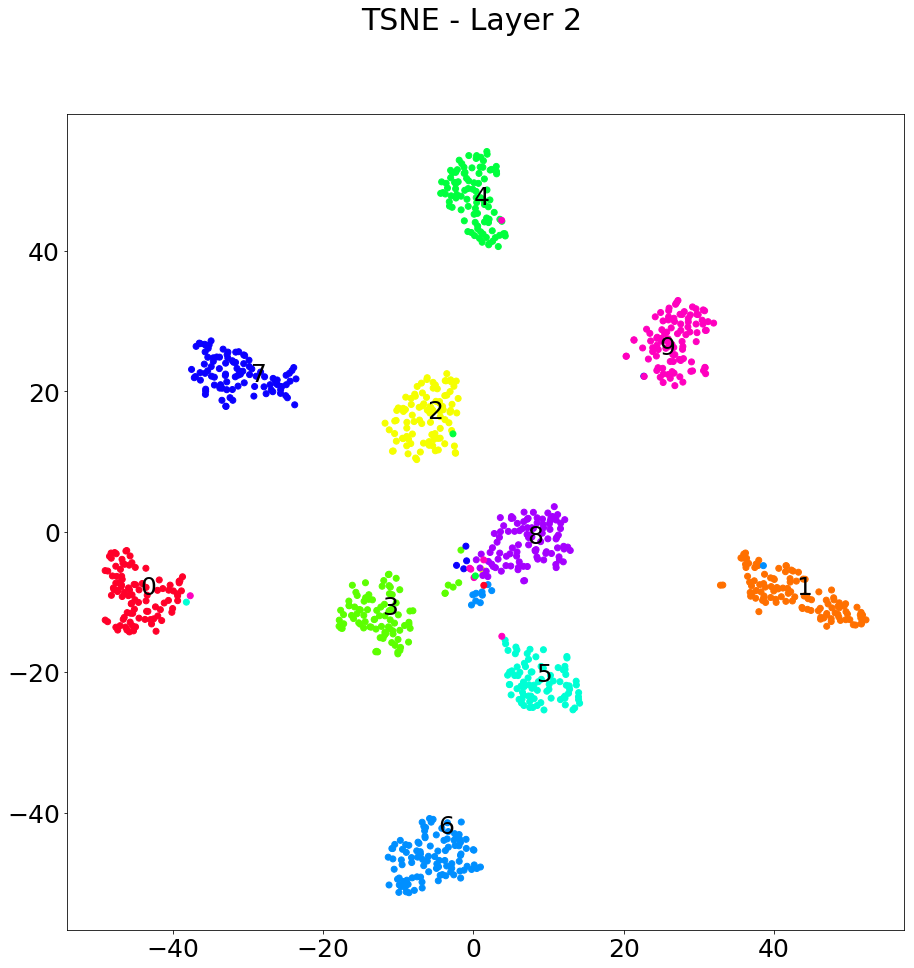

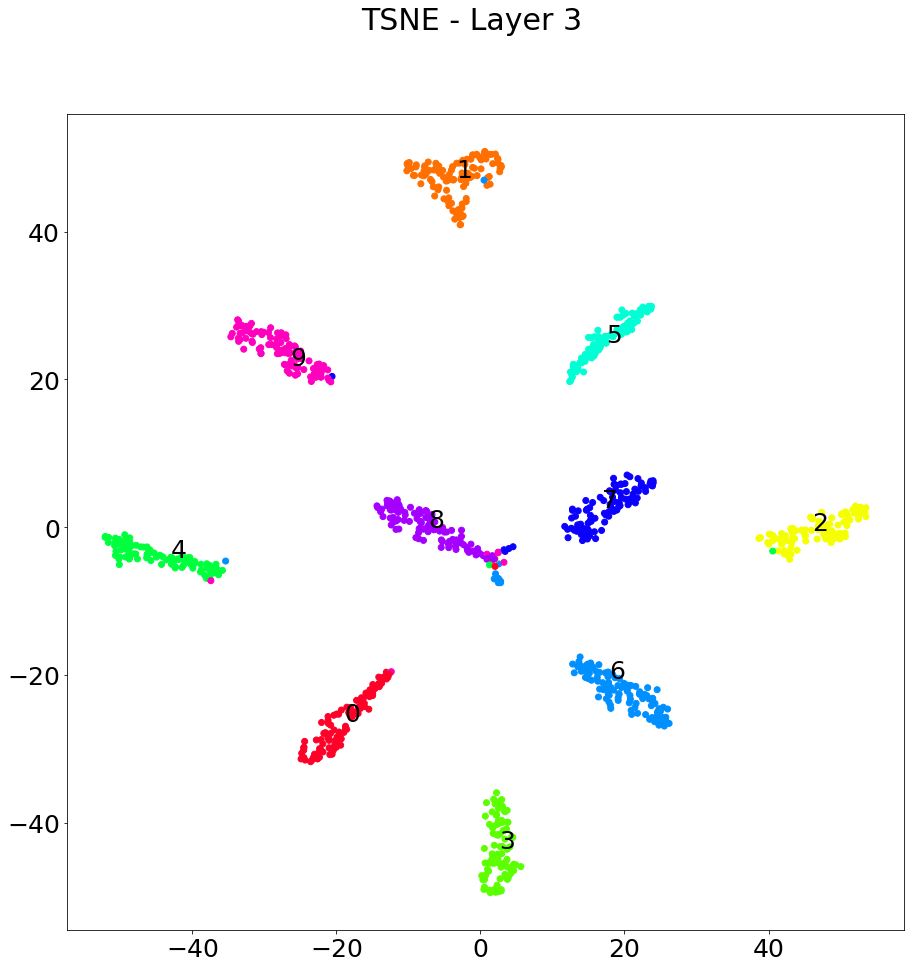

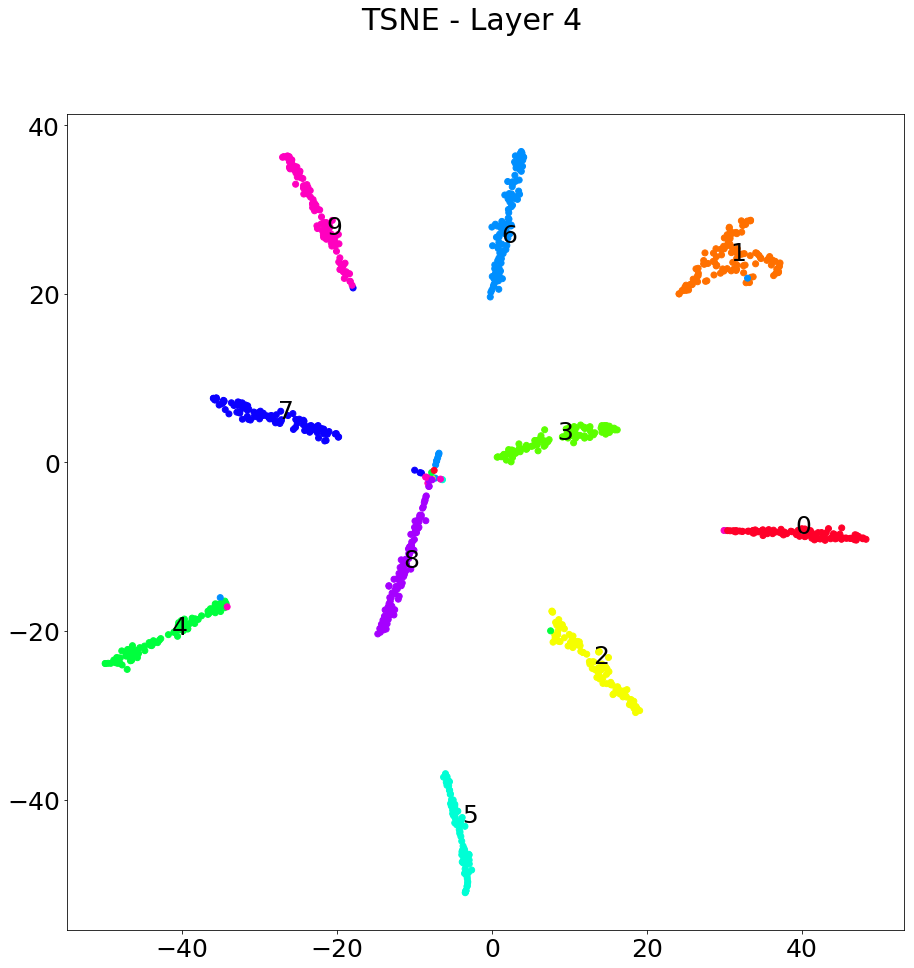

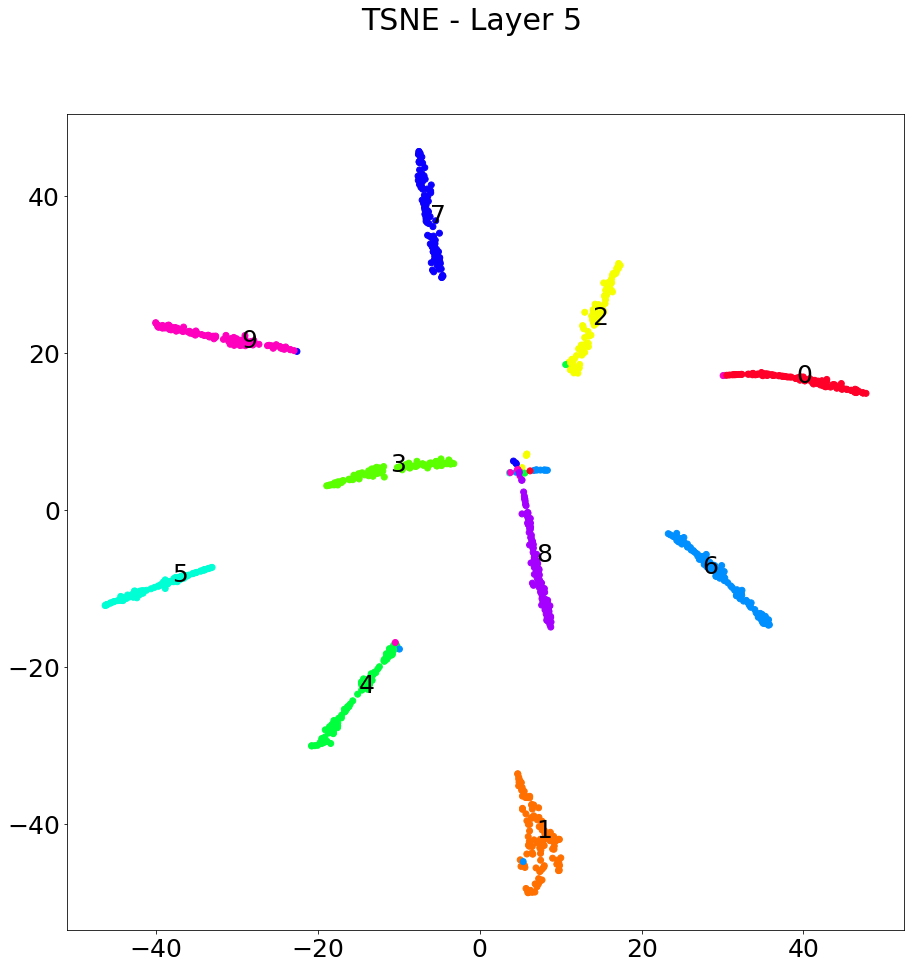

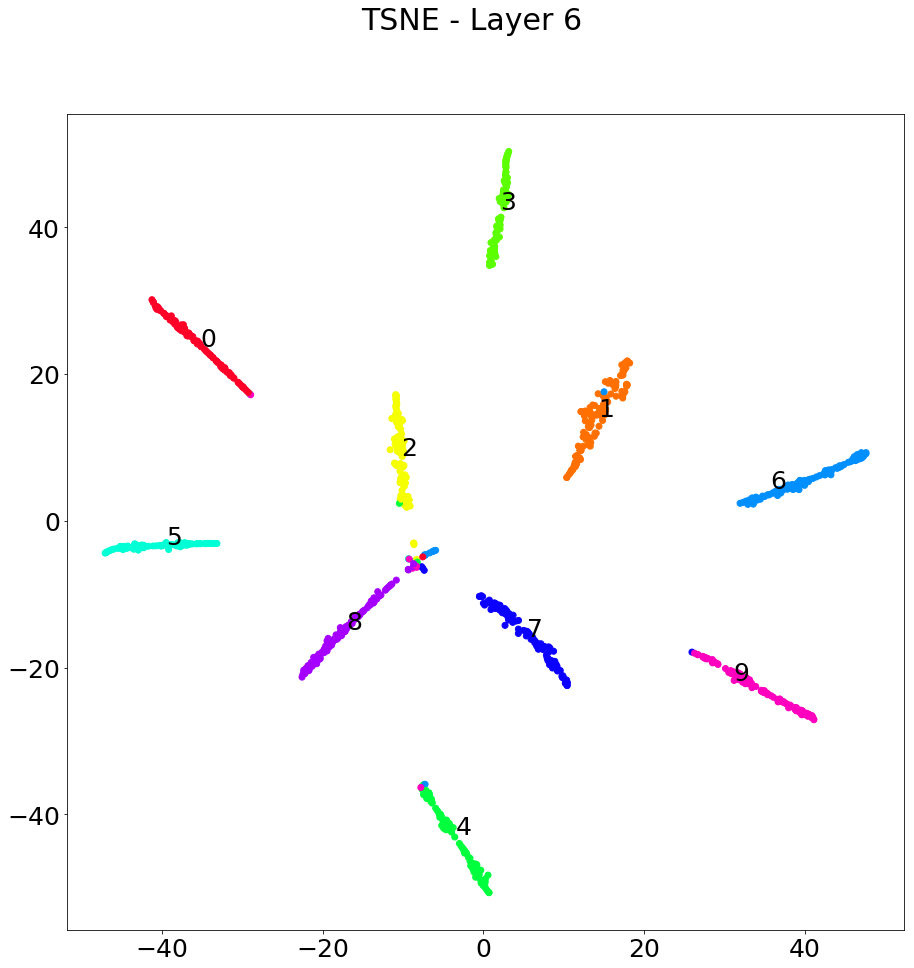

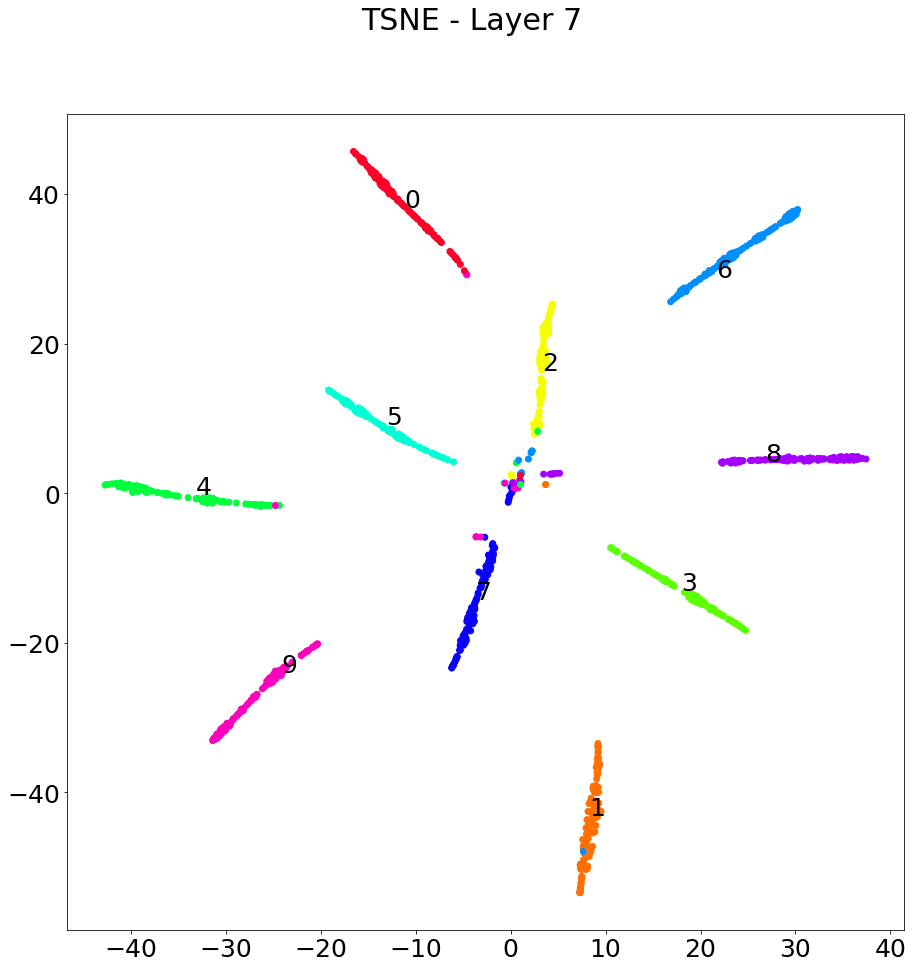

In [57]:
for _layer in output_dict.keys():
  tsne_embed_plot(output_dict[_layer].cpu().detach().numpy(), y_batch, 'TSNE - Layer {}'.format(_layer[1]) )

#### Obsevations for tSNE and PCA plots
- **Input data**
 - The raw input image samples seem to have a distinction in the tSNE plot, but it does not seem simple to classify
 - PCA plot shows no discernable distinction between the input target groups
- **Neural Network layer outputs**
 - Performing PCA and tSNE on the outputs from hidden layers gives us a view into the features produced at each layer, and the distinction between groups
 - For both PCA and tSNE, the target groups are increasingly easier to separate with increase in network depth
 - The distinction is more prominent using tSNE, especially for the last few layers

## Problem 2: Speech Denoising Using Deep Learning [5 points]


### Downloading data from Google Drive

#### Retriveing file name and Id for Homework 1 data

In [0]:
# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters

# folder_id_hw1 = '1-A0DlUFiQBRkxoeXkyTdRQCLpnpiuNPh'
if gdrive_connect:
  file_list = drive.ListFile({'q': "'1-A0DlUFiQBRkxoeXkyTdRQCLpnpiuNPh' in parents and trashed=false"}).GetList()
  for file in file_list:
    print('title {}, id {}'.format(file['title'], file['id']))

#### Downloading HW1 data

In [0]:
if gdrive_connect:
  output_file = os.path.join(data_path, 'data.zip')
  temp_file = drive.CreateFile({'id': '1MD45n52vqK_2PG5kUG7WZ4h71Xg-DsQl'})
  temp_file.GetContentFile(output_file)

### Extract data files from zip file in folder

In [60]:
# If not utilizing gdrive, upload data.zip files to following path:
print("Please upload data.zip on following path: ",data_path)


Please upload data.zip on following path:  /content/data/


In [0]:
# Extract files
with zipfile.ZipFile(data_path + '/data.zip', 'r') as zip_ref:
      zip_ref.extractall(data_path)


### Reading audio files

In [62]:
# Get audio files list from directory
audio_files = [file for file in os.listdir(data_path) if '.wav' in file]
audio_files

['test_s_02_recons.wav',
 'train_dirty_male.wav',
 'test_x_01.wav',
 'test_x_02.wav',
 'train_clean_male.wav',
 'test_s_01_recons.wav']

In [0]:
# Read audio files and store in a dictionary
audio_data = {file : librosa.load(data_path + file , sr=None) for file in audio_files}

In [64]:
len(audio_data)

6

In [65]:
# Audio file names
audio_data.keys()

dict_keys(['test_s_02_recons.wav', 'train_dirty_male.wav', 'test_x_01.wav', 'test_x_02.wav', 'train_clean_male.wav', 'test_s_01_recons.wav'])

### 2.6 Perform STFT on train data and convert to spectograms (matrix representation of signals)

In [0]:
# Ground truth
S=librosa.stft(audio_data['train_clean_male.wav'][0], n_fft=1024, hop_length=512)

# Train data
X=librosa.stft(audio_data['train_dirty_male.wav'][0], n_fft=1024, hop_length=512)

In [67]:
S.shape

(513, 2459)

In [68]:
X.shape

(513, 2459)

### 2.7 Taking absolute magnitude

In [0]:
S_abs = np.abs(S)
X_abs = np.abs(X)


### Transpose and use cuda device for further access

In [0]:
data = torch.from_numpy(X_abs.transpose()).to(device)
target = torch.from_numpy(S_abs.transpose()).to(device)

In [71]:
data.shape

torch.Size([2459, 513])

### Define pytorch DataLoader for minibatching

In [0]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
                TensorDataset(data, target),
                batch_size=batch_size, shuffle=True)

### 2.8 Training deep neural network
- 3 hidden layers
- 1024 hidden units

#### Defining PyTorch neural network class with feed forward function

In [0]:

input_size = 513
hidden_size = 1024
target_size = 513

class DNN3(nn.Module):
  def __init__(self):
    super(DNN3, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc2_bn = nn.BatchNorm1d(hidden_size)
    self.fc3 = nn.Linear(hidden_size, hidden_size)
    self.fc3_bn = nn.BatchNorm1d(hidden_size)
    self.fc4 = nn.Linear(hidden_size, hidden_size)
    self.fc4_bn = nn.BatchNorm1d(hidden_size)
    self.fc5 = nn.Linear(hidden_size, target_size)

  def forward(self, x, all_layers = False):
    output_dict = {}
    x = self.fc1(x)
    x = F.relu(x)
    output_dict.update( {'x1' : x} )

    x = self.fc2_bn(self.fc2(x))
    x = F.relu(x)
    output_dict.update( {'x2' : x} )

    x = self.fc3_bn(self.fc3(x))
    x = F.relu(x)
    output_dict.update( {'x3' : x} )

    x = self.fc4_bn(self.fc4(x))
    x = F.relu(x)
    output_dict.update( {'x4' : x} )

    x = self.fc5(x)
    x = F.relu(x)
    output_dict.update( {'x5' : x} )

    if all_layers:
      return x, output_dict
    else:
      return x  
    

#### Training loop

In [0]:
epochs = 2000
learning_rate = 0.0001
train_losses = []

def train(epoch):

  total_train_loss = 0
  correct_train = 0

  net.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    
    data = data.to(device)
    target = target.to(device)
    
    # Flatten MNIST images into a 784 long vector
    data = data.view(data.shape[0], -1).to(device)

    # Initialize zero gradients
    optimizer.zero_grad()

    # Train neural network on dataset
    output = net(data)

    # Get training loss
    train_loss = loss(output, target)
    
    # Perform backpropagation
    train_loss.backward()
    optimizer.step()
    
    # Summing losses for all batches
    total_train_loss += train_loss.item()

    # Store training loss
    train_losses.append(train_loss.item())
    
  print('Train Epoch: {}\nTrain Loss = {:.4f} \t'.format(
    epoch, train_loss.item()))
  
  
  
  # Save model
  torch.save(net.state_dict(), data_path + 'model_tuned.pth')
  torch.save(optimizer.state_dict(), data_path + 'optimizer.pth')
  if gdrive_connect:
    net_file.SetContentFile(data_path + 'model_tuned.pth')
    net_file.Upload()
     

#### Creating neural network model object

In [0]:
net = DNN3()
net = net.to(device)

#### Optimizer and loss function to be used

In [0]:
# define optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# define loss function
loss = nn.MSELoss()

#### Training and testing neural network for multiple epochs

In [77]:
timestr = time.strftime("%Y%m%d-%H%M%S")
print (timestr)
if gdrive_connect:
  net_file = drive.CreateFile({'title' : 'model_2_tuned_{}.pth'.format(timestr)})

  
for _epoch in range(1, epochs + 1):
  # Training model using train function
  train(_epoch)


20190929-233326
Train Epoch: 1
Train Loss = 0.0297 	
Train Epoch: 2
Train Loss = 0.0527 	
Train Epoch: 3
Train Loss = 0.0193 	
Train Epoch: 4
Train Loss = 0.0669 	
Train Epoch: 5
Train Loss = 0.0193 	
Train Epoch: 6
Train Loss = 0.0127 	
Train Epoch: 7
Train Loss = 0.0316 	
Train Epoch: 8
Train Loss = 0.0111 	
Train Epoch: 9
Train Loss = 0.0134 	
Train Epoch: 10
Train Loss = 0.0136 	
Train Epoch: 11
Train Loss = 0.0108 	
Train Epoch: 12
Train Loss = 0.0217 	
Train Epoch: 13
Train Loss = 0.0082 	
Train Epoch: 14
Train Loss = 0.0110 	
Train Epoch: 15
Train Loss = 0.0155 	
Train Epoch: 16
Train Loss = 0.0758 	
Train Epoch: 17
Train Loss = 0.0125 	
Train Epoch: 18
Train Loss = 0.0195 	
Train Epoch: 19
Train Loss = 0.0112 	
Train Epoch: 20
Train Loss = 0.0138 	
Train Epoch: 21
Train Loss = 0.0094 	
Train Epoch: 22
Train Loss = 0.0260 	
Train Epoch: 23
Train Loss = 0.0090 	
Train Epoch: 24
Train Loss = 0.0089 	
Train Epoch: 25
Train Loss = 0.0099 	
Train Epoch: 26
Train Loss = 0.0131 	
Train

In [78]:
# Save trained model
torch.save(net.state_dict(), data_path + 'final_model_2_tuned.pth')

timestr = time.strftime("%Y%m%d-%H%M%S")
print (timestr)

if gdrive_connect:
  net_file = drive.CreateFile({'title' : 'final_model_2_tuned_{}.pth'.format(timestr)})

  net_file.SetContentFile(data_path + 'final_model_2_tuned.pth')
  net_file.Upload()      

20190929-234307


### 2.10 Preprocessing and feedforward on test data

#### STFT on test audio

In [0]:
test_x_01=librosa.stft(audio_data['test_x_01.wav'][0], n_fft=1024, hop_length=512)
test_x_02=librosa.stft(audio_data['test_x_02.wav'][0], n_fft=1024, hop_length=512)

#### Absolute magnitude

In [0]:
test_x_01_abs = np.abs(test_x_01)
test_x_02_abs = np.abs(test_x_02)

#### Feedforward function for data after STFT

In [0]:
def stft_feedforward(data):

  # Flatten 
  data = torch.from_numpy(data.transpose()).to(device)

  # Flatten MNIST images into a 784 long vector
  data = data.view(data.shape[0], -1).to(device)

  # Initialize zero gradients
  optimizer.zero_grad()

  # Train neural network on dataset
  return net(data)


#### Feedforward on test data

In [0]:
test_shat_01_abs = stft_feedforward(test_x_01_abs).cpu().detach().numpy()
test_shat_02_abs = stft_feedforward(test_x_02_abs).cpu().detach().numpy()

### 2.10 Recover Clean Speech

#### Recover complex valued speech spectogram

In [0]:
test_s_01 = np.multiply((test_x_01/test_x_01_abs), test_shat_01_abs.T)
test_s_02 = np.multiply((test_x_02/test_x_02_abs), test_shat_02_abs.T)

#### Recover clean time domain speech signal

In [0]:
test_s_01_clean = librosa.istft(test_s_01, hop_length = 512)
test_s_02_clean = librosa.istft(test_s_02, hop_length = 512)

#### Write cleaned up speech signal

In [0]:
librosa.output.write_wav(data_path + 'test_s_01_recons.wav', test_s_01_clean, sr = audio_data['test_x_01.wav'][1])
librosa.output.write_wav(data_path + 'test_s_02_recons.wav', test_s_02_clean, sr = audio_data['test_x_02.wav'][1])

### Play dirty and cleaned up speech signals

#### Dirty signal *test_x_01.wav*

In [86]:
ipd.Audio(data_path + 'test_x_01.wav')

#### Cleaned signal for *test_x_01.wav*

In [87]:
ipd.Audio(data_path + 'test_s_01_recons.wav')

#### Dirty signal *test_x_02.wav*

In [88]:
ipd.Audio(data_path + 'test_x_02.wav')

#### Cleaned signal *test_x_02.wav*

In [89]:
ipd.Audio(data_path + 'test_s_02_recons.wav')